## Laboratorium 8.2

## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---


### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:

```python
fps = source.get(cv2.CAP_PROP_FPS)
```

Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).


In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torchvision.transforms.functional import to_pil_image

from IPython.display import HTML
from IPython.display import display
from typing import Any
import numpy as np

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.


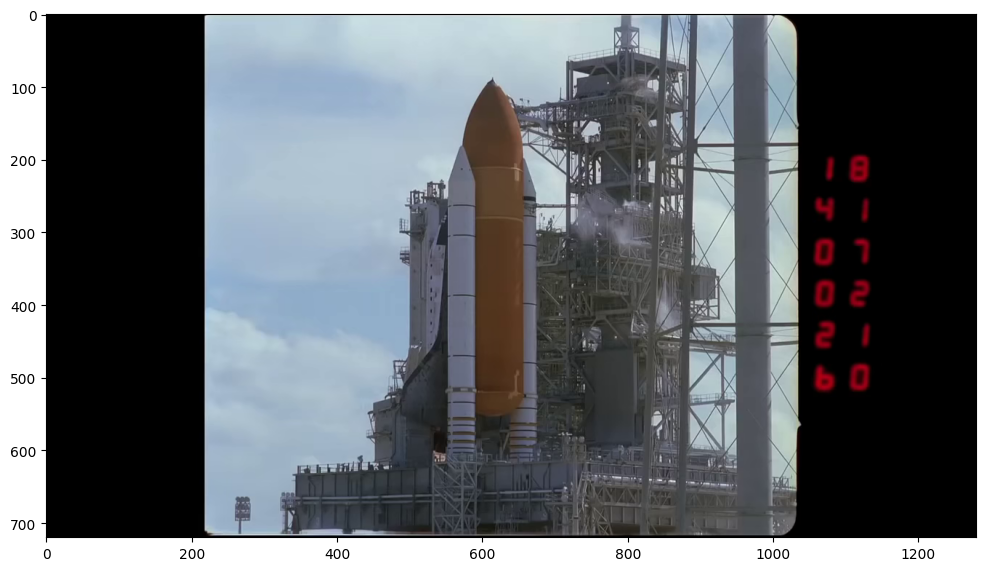

In [2]:
source = cv2.VideoCapture("dane/shuttle.mp4")
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(frame[..., ::-1])

In [3]:
def disp_hsv_hist(image_bgr: np.ndarray):
    img_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv)

    # display hisrogram for each channel
    plt.subplots(2, 4, figsize=(16, 12))

    plt.subplot(2, 4, 1)
    plt.hist(h.ravel(), 256, (0, 256), color="r")
    plt.title("Hue")

    plt.subplot(2, 4, 2)
    plt.hist(s.ravel(), 256, (0, 256), color="g")
    plt.title("Saturation")

    plt.subplot(2, 4, 3)
    plt.hist(v.ravel(), 256, (0, 256), color="b")
    plt.title("Value")

    plt.subplot(2, 4, 4)
    plt.hist(h.ravel(), 256, (0, 256), color="r", alpha=0.5)
    plt.hist(s.ravel(), 256, (0, 256), color="g", alpha=0.5)
    plt.hist(v.ravel(), 256, (0, 256), color="b", alpha=0.5)
    plt.legend(["Hue", "Saturation", "Value"])
    plt.title("Original Image")

    plt.subplot(2, 4, 5)
    plt.imshow(h, cmap="gray")
    plt.title("Hue")

    plt.subplot(2, 4, 6)
    plt.imshow(s, cmap="gray")
    plt.title("Saturation")

    plt.subplot(2, 4, 7)
    plt.imshow(v, cmap="gray")
    plt.title("Value")

    plt.subplot(2, 4, 8)
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Image")

    plt.show()

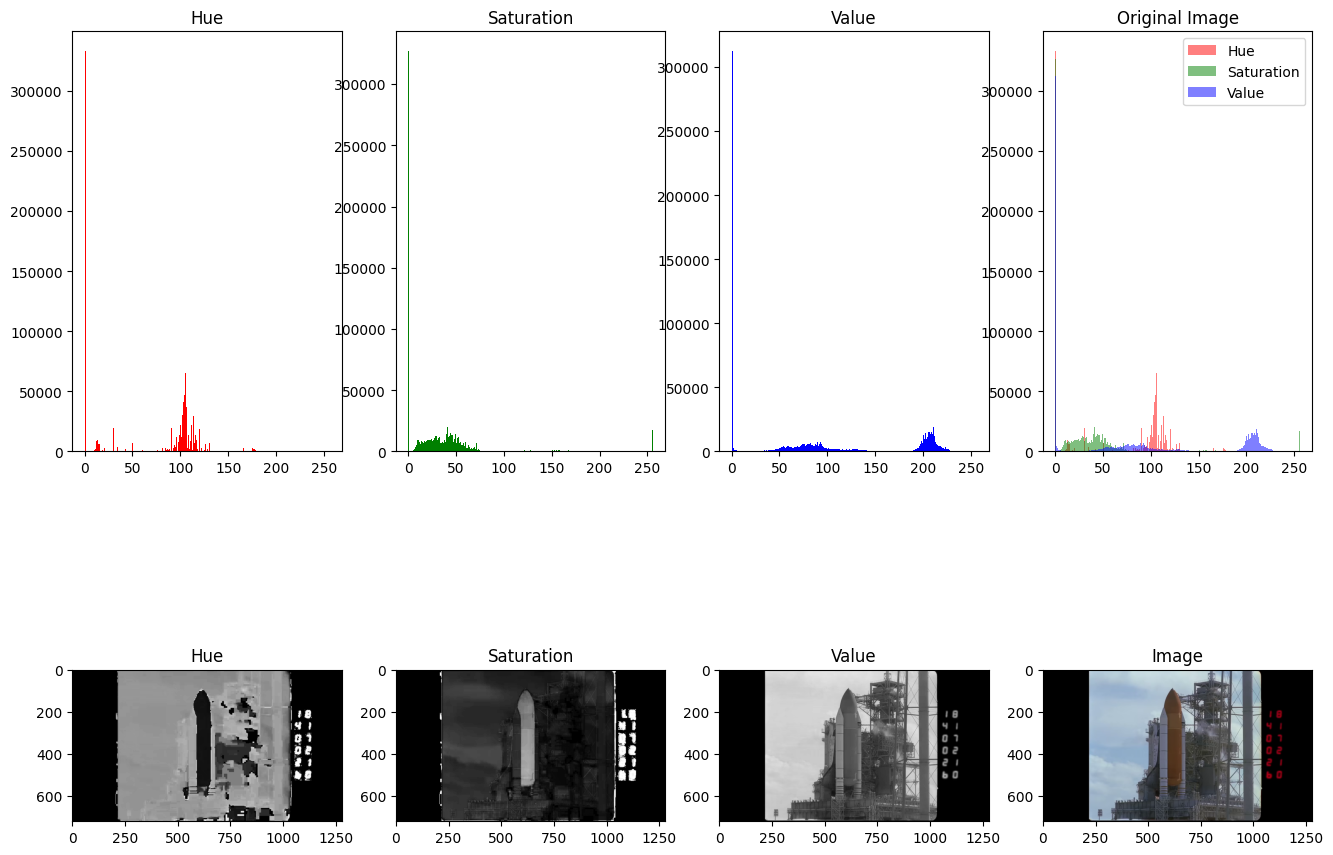

In [4]:
frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(frame_hsv)
disp_hsv_hist(frame)

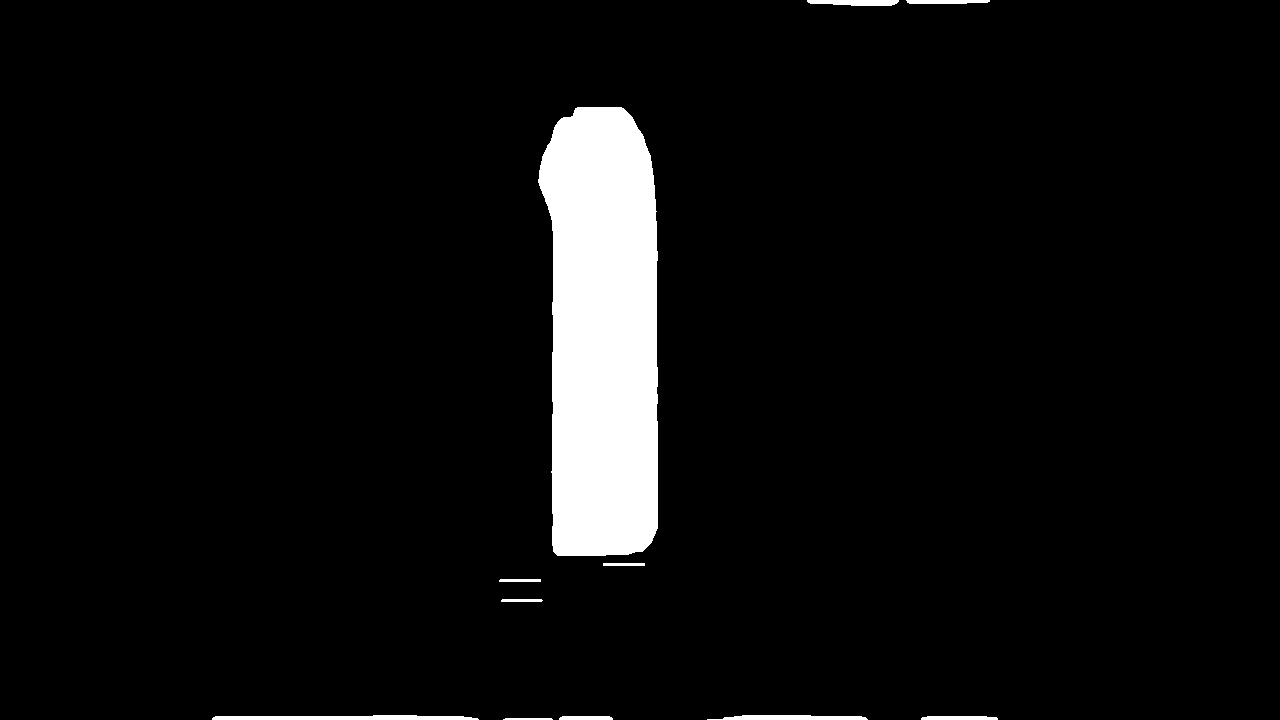

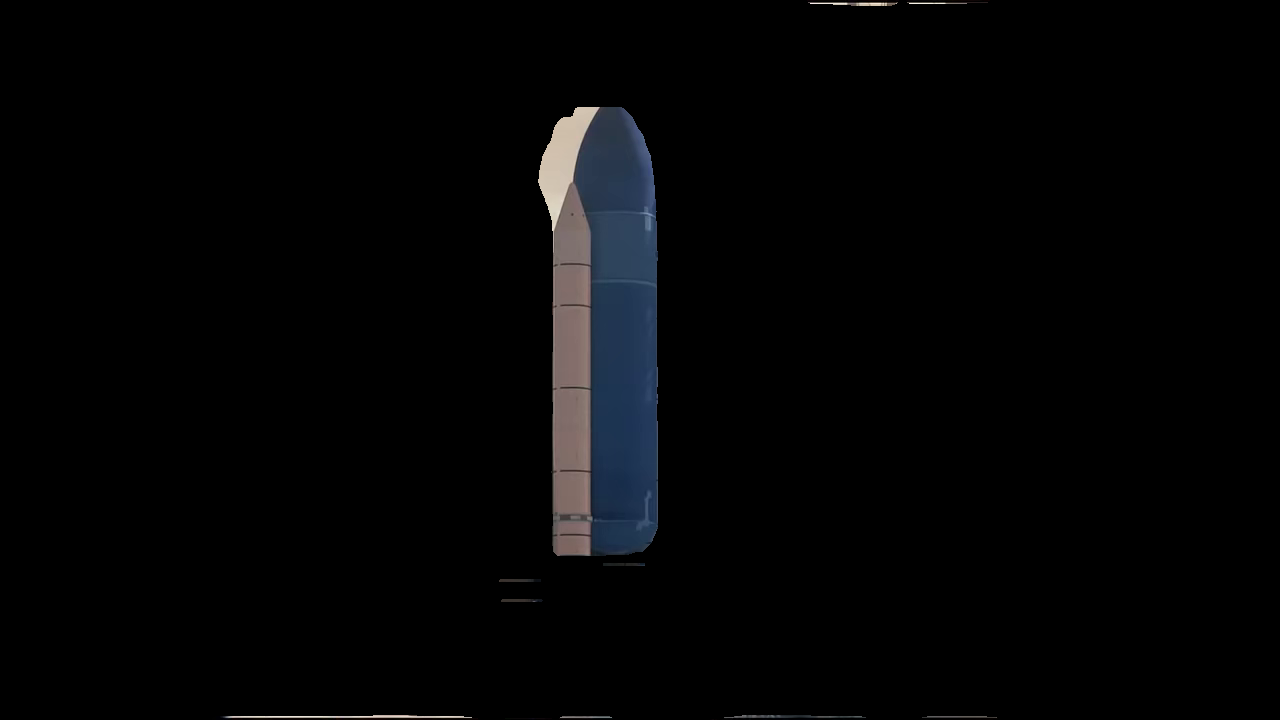

In [5]:
def get_mask(frame_bgr: np.ndarray):
    frame_hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    frame_hsv[:, :250, :] = 0
    frame_hsv[:, 1000:, :] = 0
    s = cv2.split(frame_hsv)[1]
    s_gauss = cv2.GaussianBlur(s, (15, 15), 0)
    mask = cv2.threshold(s_gauss, 80, 1, cv2.THRESH_BINARY)[1]

    # expand horizontally
    kernel = np.ones((1, 40), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask = np.roll(mask, -20, axis=1)

    return mask


mask = get_mask(frame)
display(to_pil_image(mask * 255))

frame_masked = frame * np.stack((mask, mask, mask), axis=-1)
display(to_pil_image(frame_masked))

<class 'numpy.ndarray'>
len(features)=10


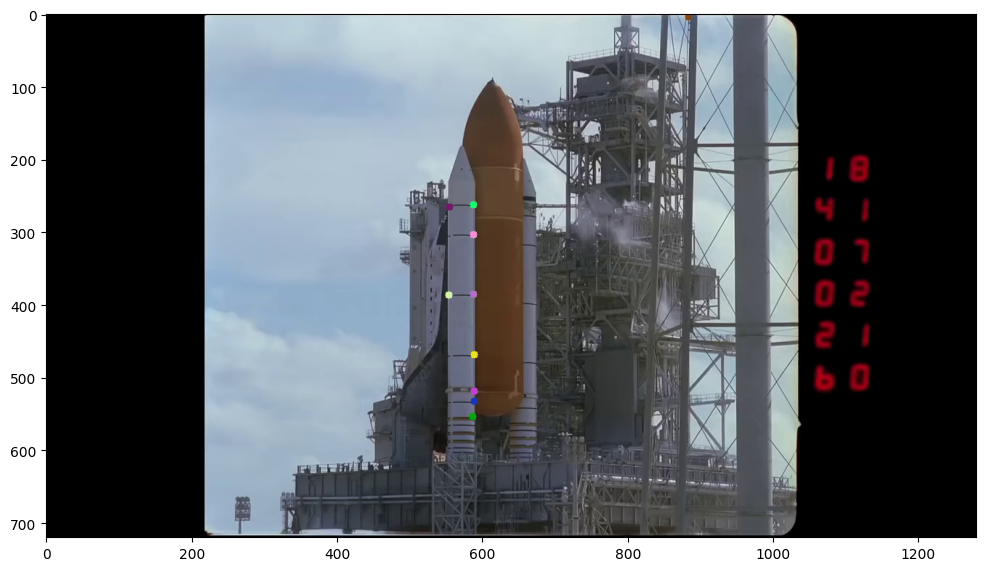

In [6]:
def get_good_features(frame: np.ndarray):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    p0 = cv2.goodFeaturesToTrack(
        gray,
        mask=mask,
        maxCorners=40,
        qualityLevel=0.15,
        minDistance=7,
        blockSize=7,
    )

    print(type(p0))
    return p0


def draw_features(features: np.ndarray, frame: np.ndarray):
    frame = frame.copy()
    features = features.astype(np.int32)

    for i in features:
        x, y = i.ravel()
        color = np.random.randint(0, 256, size=(3,))
        color = [int(channel) for channel in color]
        cv2.circle(frame, (x, y), 5, color, -1)

    _, axes = plt.subplots(1, 1, figsize=(12, 12))
    axes.imshow(frame[..., ::-1])


features = get_good_features(frame)
draw_features(features, frame)
print(f"{len(features)=}")

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).


In [7]:
def initialize_video_source(source: cv2.VideoCapture):
    """Initialize the video source and return the first frame and status."""
    status, frame_next = source.read()
    if not status:
        print("Failed to read the video source.")
        return None, None
    return status, frame_next


def calculate_optical_flow_params():
    """Return the parameters for Lucas-Kanade optical flow calculation."""
    lk_params = dict(
        winSize=(17, 17),
        maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    return lk_params


def detect_features(frame, mask=None):
    """Detect Shi-Tomasi corners in the given frame."""
    shiTomasiParams = dict(maxCorners=40, qualityLevel=0.15, minDistance=7, blockSize=7)
    return cv2.goodFeaturesToTrack(frame, mask=mask, **shiTomasiParams)


def draw_optical_flow(good_new, good_old, result_img, frame_next, color, trajectories):
    """Draw the optical flow lines and update trajectories."""
    # Initialize frame_next_result as a copy of frame_next to ensure it is defined
    frame_next_result = frame_next.copy()

    for i, (new, old) in enumerate(zip(good_new, good_old)):
        new_x, new_y = new.ravel()
        old_x, old_y = old.ravel()

        # Filter out points near the picture top
        if new_y < 20 or old_y < 20:
            continue

        result_img = cv2.line(
            result_img,
            (int(new_x), int(new_y)),
            (int(old_x), int(old_y)),
            color[i].tolist(),
            2,
        )

        frame_next_result = cv2.circle(
            frame_next_result, (int(new_x), int(new_y)), 5, color[i].tolist(), -1
        )

        trajectories[i].append((new_x, new_y))

    return result_img, frame_next_result


def create_animation(frames):
    """Create an animation from the list of frames."""
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_axis_off()
    ax.set_title("Optical Flow - Lucas-Kanade method")
    im = ax.imshow(frames[0])
    fig.tight_layout()

    def update(frame):
        im.set_array(frame)
        return [im]

    anim = FuncAnimation(fig, update, frames=frames, interval=15, blit=True)
    plt.close(fig)
    return anim


def base_loop_with_animation(
    source: cv2.VideoCapture,
) -> tuple[Any | None, list[Any], list[Any]]:
    # Initialize video source and parameters
    status, frame_next = initialize_video_source(source)
    if not status:
        return None, None, None

    mask = get_mask(frame_next)
    frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)
    lk_params = calculate_optical_flow_params()
    color = np.random.randint(0, 255, (100, 3))

    # Detect initial features
    p0 = detect_features(frame_next_gray, mask=mask)
    if p0 is None:
        print("No features detected.")
        return None, None, None

    result_img = np.zeros_like(frame_next)
    trajectories = [[] for _ in range(len(p0))]
    frames = []

    # Main loop for processing frames
    while status:
        frame = frame_next
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        status, frame_next = source.read()

        if not status:
            break

        frame_next_gray = cv2.cvtColor(frame_next, cv2.COLOR_BGR2GRAY)
        if p0 is None:
            break

        # Calculate optical flow
        p1, st, _ = cv2.calcOpticalFlowPyrLK(
            frame_gray,
            frame_next_gray,
            p0,
            None,
            **lk_params,
        )

        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

        # Draw optical flow and update trajectories
        result_img, frame_next_result = draw_optical_flow(
            good_new, good_old, result_img, frame_next, color, trajectories
        )

        img = cv2.add(frame_next_result, result_img)
        frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        p0 = good_new.reshape(-1, 1, 2)

    source.release()

    # Create animation
    anim = create_animation(frames)

    return anim, frames, trajectories

In [8]:
source = cv2.VideoCapture("dane/shuttle.mp4")
anim, frames, trajectories = base_loop_with_animation(source)

In [9]:
# matplotlib.rcParams["animation.embed_limit"] = 40
# source = cv2.VideoCapture("dane/shuttle.mp4")
# fps = source.get(cv2.CAP_PROP_FPS)

# html_video, frames, trajectories = base_loop_with_animation(source)
display(HTML(anim.to_html5_video()))

In [10]:
anim.save("output.mp4")

In [11]:
def plot_trajectories_xy(trajectories: list[list[tuple[np.float32, np.float32]]]):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))

    for i, trajectory in enumerate(trajectories):
        x_coords = [point[0] for point in trajectory]
        y_coords = [point[1] for point in trajectory]

        plt.plot(
            x_coords,
            y_coords,
            marker="o",
            markersize=2,
            label=f"Trajectory {i + 1}",
        )

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Trajectories (0,0 at Top-Left)")

    plt.gca().invert_yaxis()

    plt.legend()
    plt.grid(True)

    plt.show()

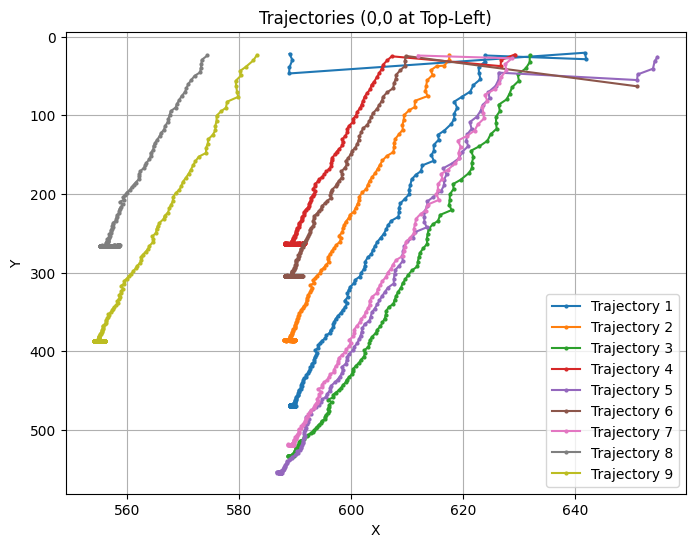

In [12]:
trajectories = [trajectory for trajectory in trajectories if trajectory]
plot_trajectories_xy(trajectories)

In [13]:
import json


def save_trajectories_to_json(trajectories, filename="trajectories.json"):
    """Save trajectories to a JSON file."""
    trajectories_serializable = [
        [(float(x), float(y)) for x, y in trajectory] for trajectory in trajectories
    ]
    with open(filename, "w") as file:
        json.dump(trajectories_serializable, file, indent=4)

In [14]:
save_trajectories_to_json(trajectories)

In [15]:
def remove_last_n_elements(trajectories, n=6):
    """Remove the first n elements from each trajectory."""
    return [trajectory[:-n] for trajectory in trajectories]

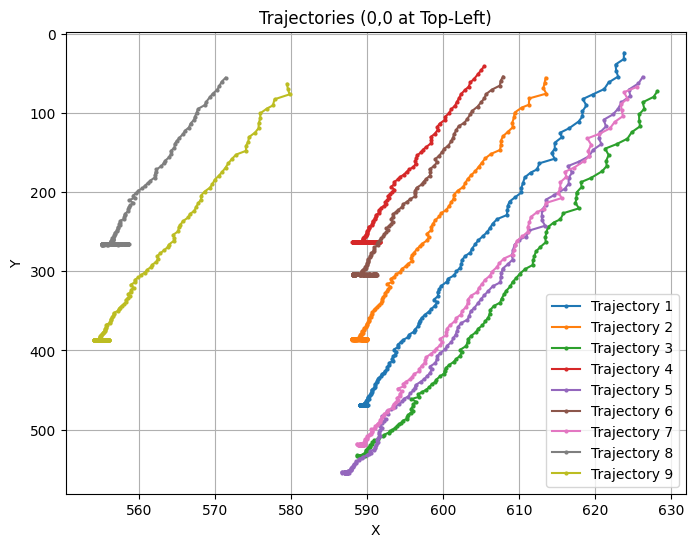

In [16]:
new_trajectories = remove_last_n_elements(trajectories, 6)
plot_trajectories_xy(new_trajectories)

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.


In [17]:
def plot_trajectories_time(trajectories: list[list[tuple[np.float32, np.float32]]]):

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, trajectory in enumerate(trajectories):
        x_coords = list(range(len(trajectory)))
        y_coords = [point[1] for point in trajectory]

        axes[0].plot(
            x_coords,
            y_coords,
            marker="o",
            markersize=2,
            label=f"Trajectory {i + 1}",
        )

    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Y")
    axes[0].set_title("Y-Coordinates Over Time")
    axes[0].invert_yaxis()
    axes[0].legend()
    axes[0].grid(True)

    for i, trajectory in enumerate(trajectories):
        time = list(range(len(trajectory)))
        x_coords = [point[0] for point in trajectory]

        axes[1].plot(
            time,
            x_coords,
            marker="o",
            markersize=2,
            label=f"Trajectory {i + 1}",
        )

    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("X")
    axes[1].set_title("X-Coordinates Over Time")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

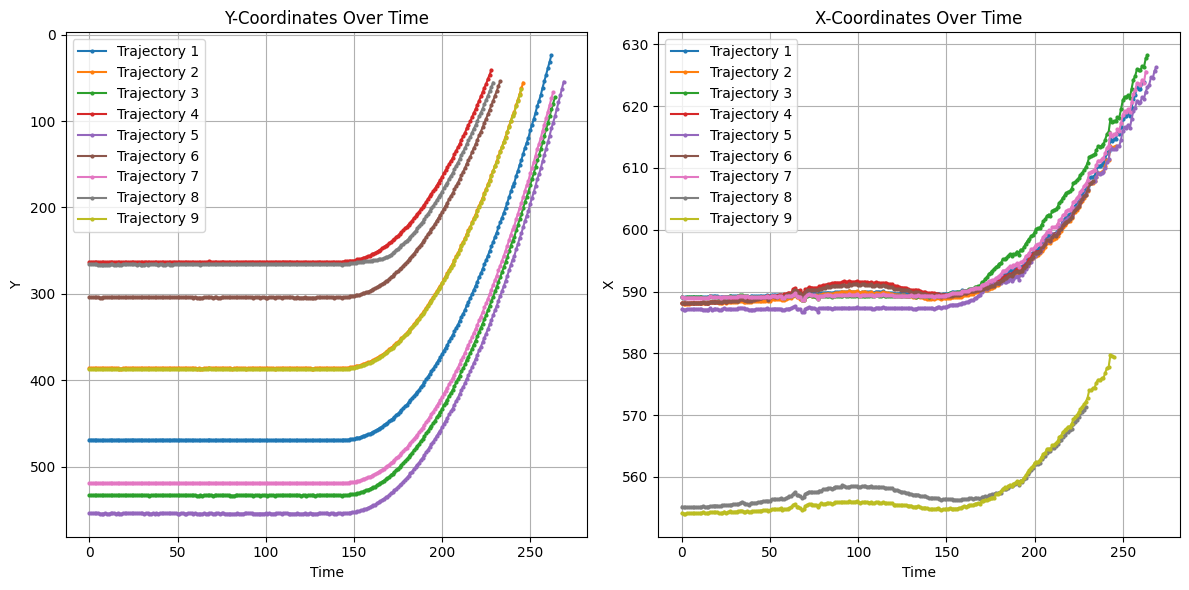

In [18]:
plot_trajectories_time(new_trajectories)

#### Compute relative trajectories (to each starting point)


In [19]:
def vector_difference(
    point1: tuple[np.float32, np.float32],
    point2: tuple[np.float32, np.float32],
) -> tuple[np.float32, np.float32]:
    """Compute the difference between two 2D vectors."""
    return point1[0] - point2[0], point1[1] - point2[1]


def compute_relative_trajectories(
    trajectories: list[list[tuple[np.float32, np.float32]]]
) -> list[list[tuple[np.float32, np.float32]]]:
    """
    Convert absolute positions in trajectories to relative positions
    (relative to the starting point of each trajectory).

    Parameters:
        trajectories: A list of trajectories, where each trajectory is a list of (x, y) points.

    Returns:
        A list of trajectories with positions converted to relative distances from the starting point.
    """
    relative_trajectories = []
    for trajectory in trajectories:
        if not trajectory:  # Skip empty trajectories
            continue
        start_pos = trajectory[0]
        relative_trajectory = [vector_difference(pos, start_pos) for pos in trajectory]
        relative_trajectories.append(relative_trajectory)
    return relative_trajectories

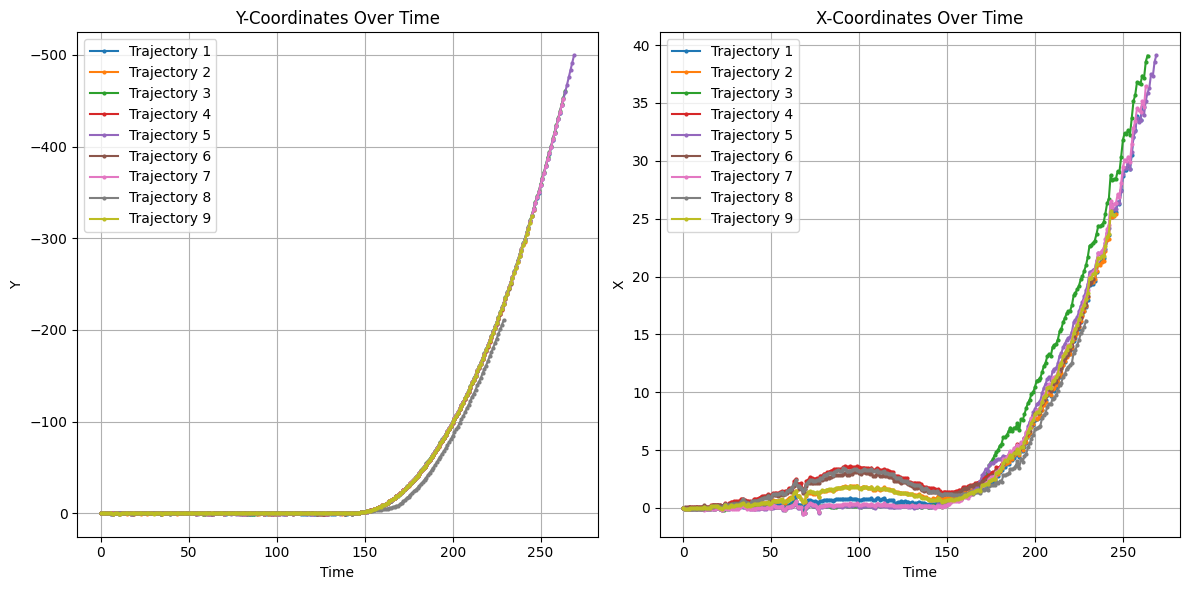

In [20]:
relative_trajectories = compute_relative_trajectories(new_trajectories)
plot_trajectories_time(relative_trajectories)

#### compute average trajectory


In [21]:
def get_average_trajectory(
    trajectories: list[list[tuple[np.float32, np.float32]]]
) -> list[tuple[np.float32, np.float32]]:
    i = 0
    count = 0
    length = max([len(trajectory) for trajectory in trajectories])
    merged = [[np.float32(0.0), np.float32(0.0)] for _ in range(length)]

    while True:
        # mergerd.append(0)
        for trajectory in trajectories:  # for each entry in the dictionary
            if (
                len(trajectory) <= i
            ):  # if the list for that entry doesn't have a element
                continue
            merged[i][0] += trajectory[i][0]
            merged[i][1] += trajectory[i][1]
            count += 1
        if count == 0:  # if there were no more elements
            merged.pop()
            break
        merged[i][0] = merged[i][0] / count
        merged[i][1] = merged[i][1] / count
        count = 0
        i += 1

    merged = [(pos[0], pos[1]) for pos in merged]
    return merged

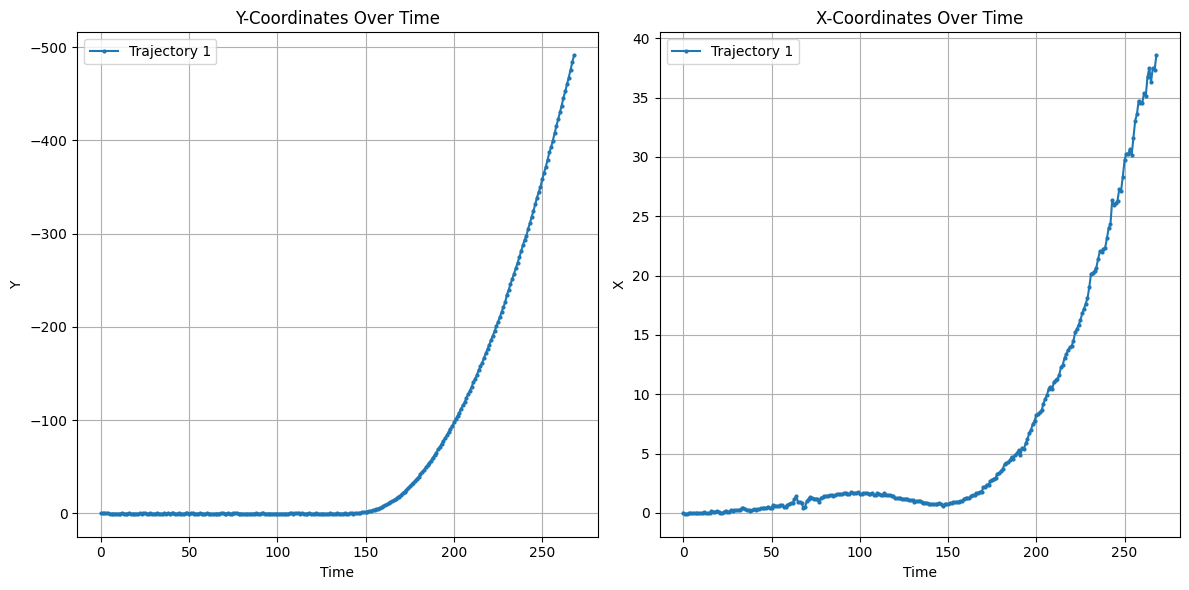

In [22]:
avearage_trajectory = get_average_trajectory(relative_trajectories)

plot_trajectories_time([avearage_trajectory])

In [23]:
print(len(trajectories))
print(trajectories[0])

9
[(np.float32(589.14197), np.float32(468.90366)), (np.float32(589.0297), np.float32(468.8193)), (np.float32(589.0678), np.float32(468.94025)), (np.float32(589.0695), np.float32(468.9336)), (np.float32(589.05646), np.float32(468.92538)), (np.float32(589.0742), np.float32(469.09048)), (np.float32(589.09247), np.float32(469.22916)), (np.float32(589.08936), np.float32(469.2904)), (np.float32(589.098), np.float32(469.01318)), (np.float32(589.0969), np.float32(469.09512)), (np.float32(589.08826), np.float32(469.44687)), (np.float32(589.09204), np.float32(469.23132)), (np.float32(589.07117), np.float32(468.7435)), (np.float32(589.072), np.float32(469.02243)), (np.float32(589.0717), np.float32(469.02194)), (np.float32(589.05164), np.float32(469.09625)), (np.float32(589.29315), np.float32(468.8013)), (np.float32(589.19806), np.float32(469.30142)), (np.float32(589.1982), np.float32(469.2988)), (np.float32(589.2049), np.float32(469.17487)), (np.float32(589.2028), np.float32(469.03378)), (np.floa

#### calculate velocity


[(np.float32(-0.077433266), np.float32(-0.077433266)), (np.float32(-0.036468506), np.float32(-0.036468506)), (np.float32(0.014333088), np.float32(0.014333088)), (np.float32(0.016292997), np.float32(0.016292997)), (np.float32(0.007317437), np.float32(0.007317437)), (np.float32(0.0060356976), np.float32(0.0060356976)), (np.float32(0.0038011344), np.float32(0.0038011344)), (np.float32(0.004930285), np.float32(0.004930285)), (np.float32(0.0016309945), np.float32(0.0016309945)), (np.float32(-0.0042182077), np.float32(-0.0042182077)), (np.float32(-0.003038194), np.float32(-0.003038194)), (np.float32(0.030019125), np.float32(0.030019125)), (np.float32(-0.0028483067), np.float32(-0.0028483067)), (np.float32(-0.034732394), np.float32(-0.034732394)), (np.float32(-0.0041436106), np.float32(-0.0041436106)), (np.float32(0.09325832), np.float32(0.09325832)), (np.float32(0.06644016), np.float32(0.06644016)), (np.float32(-0.024675153), np.float32(-0.024675153)), (np.float32(0.0148586705), np.float32(0

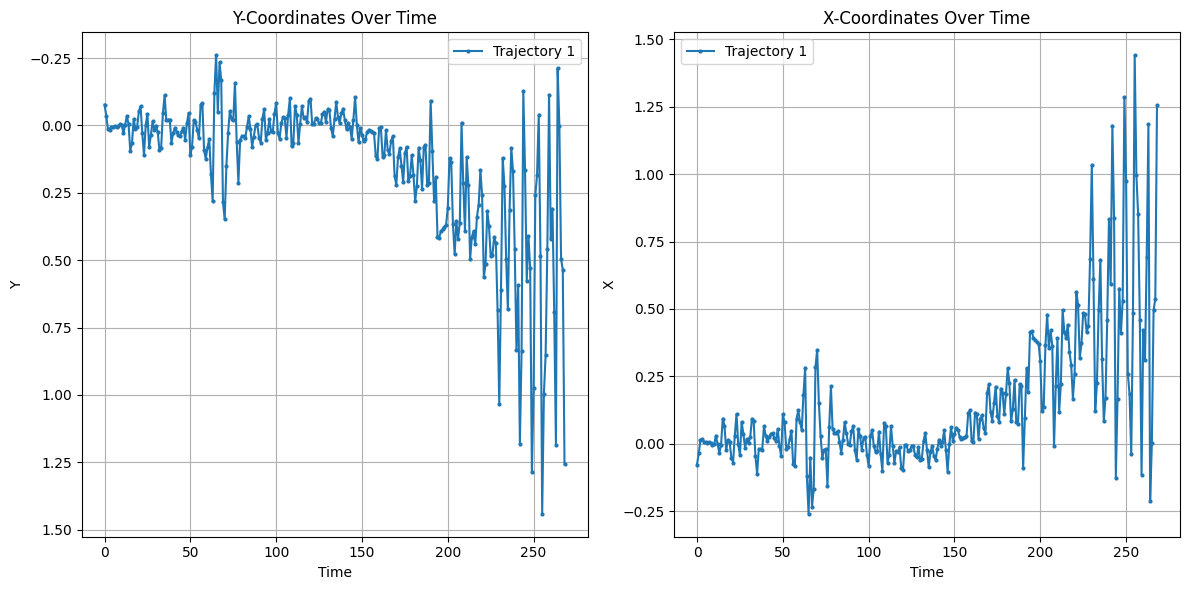

In [36]:
import numpy as np

y = [pos[0] for pos in avearage_trajectory]
dt = 1
dydt = np.gradient(y, dt)  # dy/dx 2nd order accurate

x = [pos[1] for pos in avearage_trajectory]

# print(x)
dxdt = np.gradient(y, dt)  # dy/dx 2nd order accurate

# print(dydt)
# print(dxdt)
velocity = list(zip(dydt, dxdt))
print(velocity)
plot_trajectories_time([velocity])